In [42]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose


import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

In [43]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent
DIR_external = 'data/external/'
DIR_processed = 'data/processed/'
DIR_interim = 'data/interim/'

FILE_iceShelvesShape = 'iceShelves.geojson'

In [44]:
sorrmv21 = xr.open_dataset(main_dir.parent / 'aislens_emulation/data/external/SORRMv2.1.ISMF/regridded_output/Regridded_SORRMv2.1.ISMF.FULL.nc', chunks={'Time': 36})

In [45]:
sorrmv21_draft = sorrmv21.timeMonthly_avg_ssh

In [46]:
sorrm_variability = xr.open_dataset("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability_extrapolated_fillNA_meanAdjusted.nc", chunks={'Time': 36})
sorrm_variability_flux = sorrm_variability.timeMonthly_avg_landIceFreshwaterFlux
sorrm_variability_flux = sorrm_variability_flux.rename({'Time': 'time'})

In [47]:
sorrm_variability = xr.open_dataset("/Users/smurugan9/research/aislens/AISLENS/data/processed/sorrm_variability.nc", chunks={'Time': 36})
sorrm_variability_flux = sorrm_variability.timeMonthly_avg_landIceFreshwaterFlux
sorrm_variability_flux = sorrm_variability_flux.rename({'Time': 'time'})

In [48]:
sorrm_variability_flux_testset = sorrm_variability_flux[:400]

In [49]:
from aislens.generator import eof_decomposition
from aislens.dataprep import extrapolate_catchment_over_time

In [57]:
model, eofs, pcs, nmodes, varexpl = eof_decomposition(sorrm_variability_flux_testset)

In [51]:
# read icems
icems = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)

In [52]:
from aislens.config import config

In [58]:
eofs = eofs.to_dataset()

In [54]:
eofs = eofs.rename({"mode": "Time"})

In [64]:
from aislens.utils import write_crs

eofs = write_crs(eofs)

In [60]:
eofs

<xarray.Dataset>
Dimensions:  (y: 601, x: 601, mode: 400)
Coordinates:
  * y        (y) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
  * x        (x) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 ... 393 394 395 396 397 398 399 400
Data variables:
    EOFs     (y, x, mode) float64 nan nan nan nan nan ... nan nan nan nan nan

In [76]:
from aislens.dataprep import extrapolate_catchment, merge_catchment_data, copy_subset_data

In [79]:
def extrapolate_catchment_over_modes(dataset, icems, config, var_name):
    """
    Extrapolate catchment data for each time step.
    Returns an xarray.Dataset with filled values.
    """
    modes = dataset[var_name].coords["mode"]
    shape = dataset[var_name].shape
    extrap_array = np.full(shape, np.nan)

    extrap_ds = xr.DataArray(
        extrap_array,
        coords=dataset[var_name].coords,
        dims=dataset[var_name].dims,
        attrs=dataset[var_name].attrs
        
    )
    extrap_ds = xr.Dataset({var_name: extrap_ds})

    for t in range(100):
        ds_data = dataset.isel({"mode": t}) #.rename({'x': 'x1', 'y': 'y1'})
        results = [extrapolate_catchment(ds_data, i, icems) for i in config.ICE_SHELF_REGIONS]
        merged_ds = merge_catchment_data(results)
        result_ds = copy_subset_data(ds_data, merged_ds)
        #extrap_ds[var_name][t] = result_ds[var_name]
        #extrap_ds[var_name][t] = result_ds[var_name].reindex_like(extrap_ds[var_name].isel(mode=t))
        extrap_ds[var_name][:, :, t] = result_ds[var_name].values
        print(f"Completed {var_name} time step {t}")
    return extrap_ds

In [80]:
eofs_extrapl = extrapolate_catchment_over_modes(eofs, icems, config, "EOFs")

Completed EOFs time step 0
Completed EOFs time step 1
Completed EOFs time step 2
Completed EOFs time step 3
Completed EOFs time step 4
Completed EOFs time step 5
Completed EOFs time step 6
Completed EOFs time step 7
Completed EOFs time step 8
Completed EOFs time step 9
Completed EOFs time step 10
Completed EOFs time step 11
Completed EOFs time step 12
Completed EOFs time step 13
Completed EOFs time step 14
Completed EOFs time step 15
Completed EOFs time step 16
Completed EOFs time step 17
Completed EOFs time step 18
Completed EOFs time step 19
Completed EOFs time step 20
Completed EOFs time step 21
Completed EOFs time step 22
Completed EOFs time step 23
Completed EOFs time step 24
Completed EOFs time step 25
Completed EOFs time step 26
Completed EOFs time step 27
Completed EOFs time step 28
Completed EOFs time step 29
Completed EOFs time step 30
Completed EOFs time step 31
Completed EOFs time step 32
Completed EOFs time step 33
Completed EOFs time step 34
Completed EOFs time step 35
Co

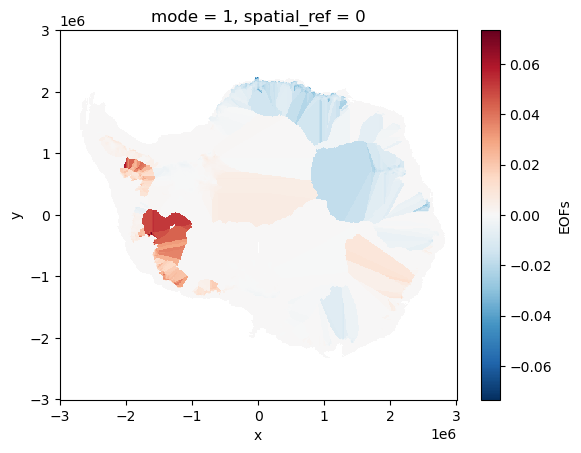

In [83]:
eofs_extrapl.EOFs[:,:,0].plot()

In [5]:
data = xr.open_dataset(main_dir / DIR_interim / 'SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE.nc')
data = data.__xarray_dataarray_variable__

#TODO: change tdim from 'time' to 'Time', as the EOF method requires.
data = data.rename({"Time":"time"})

data_norm = xr.open_dataset(main_dir / DIR_interim / 'SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_NORMALIZE.nc')
data_norm = data_norm.__xarray_dataarray_variable__

#TODO: change tdim from 'time' to 'Time', as the EOF method requires.
data_norm = data_norm.rename({"Time":"time"})

da_tmean = xr.open_dataset(main_dir / DIR_interim / 'normalize/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_TMEAN.nc')
da_tstd = xr.open_dataset(main_dir / DIR_interim / 'normalize/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_TSTD.nc')

da_tmean = da_tmean.__xarray_dataarray_variable__
da_tstd = da_tstd.__xarray_dataarray_variable__

ICESHELVES_MASK = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/smurugan9/research/aislens/AISLENS/data/interim/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE.nc'

# Variance Plot

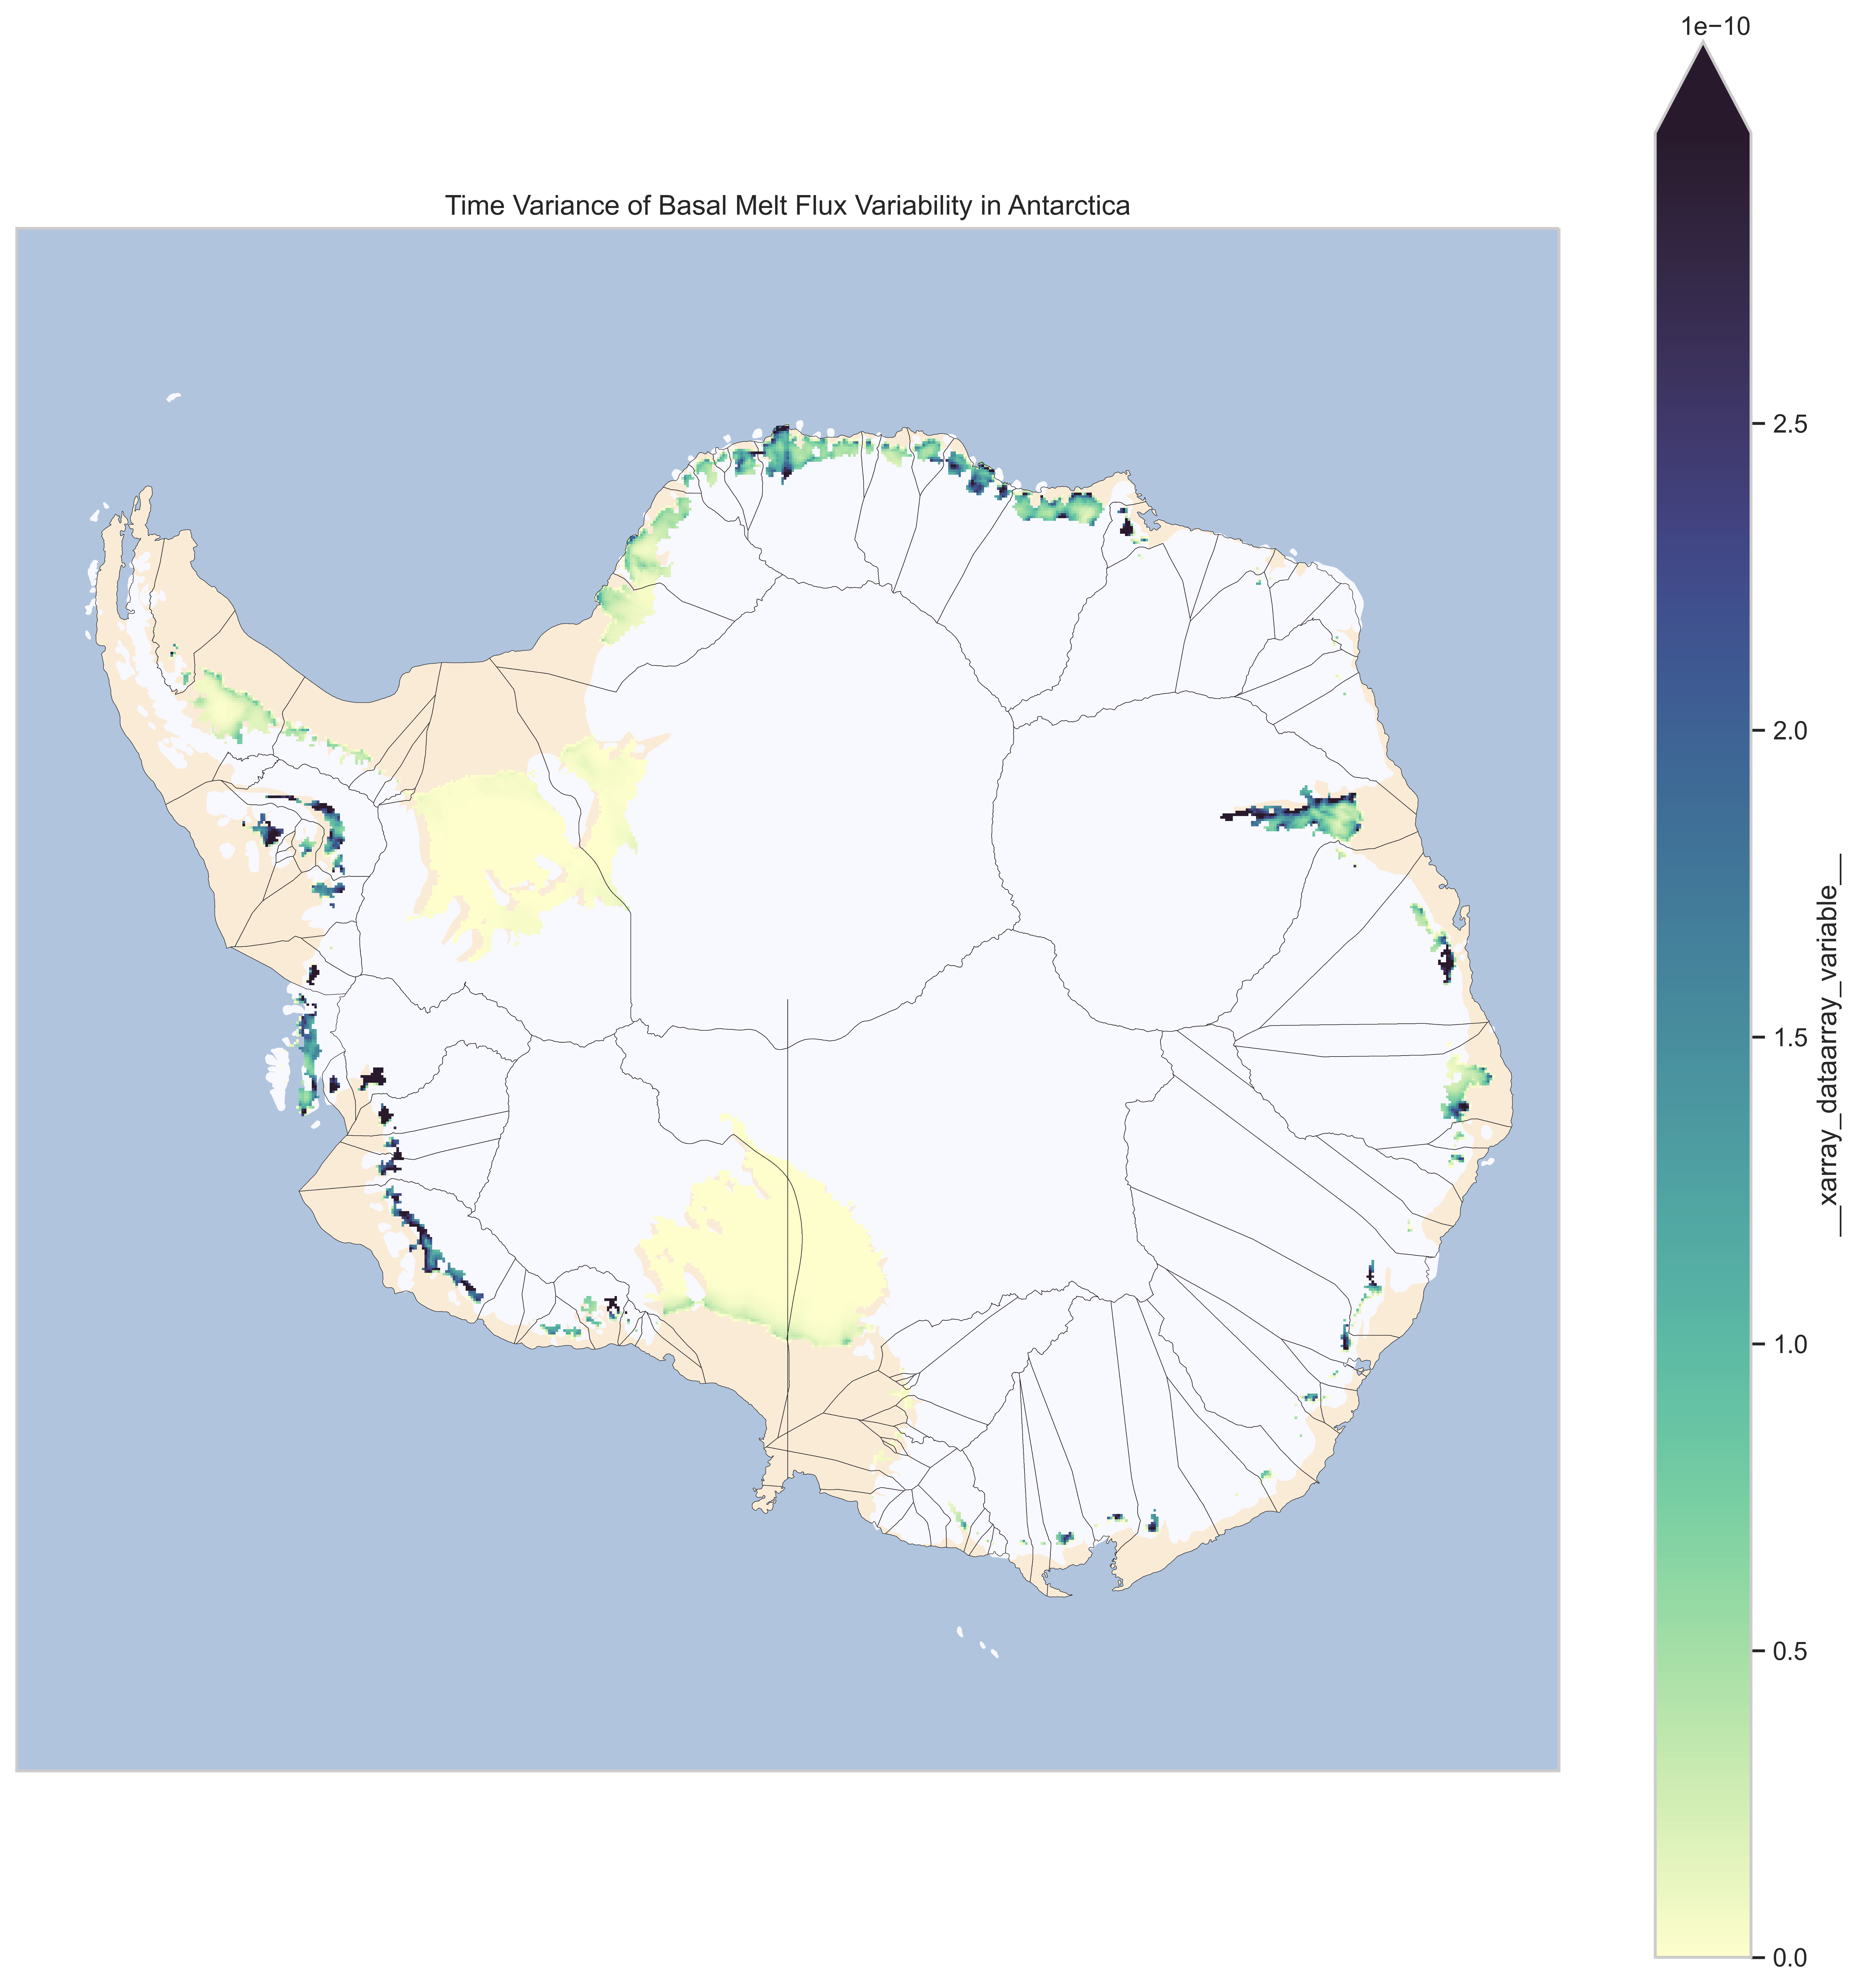

In [8]:
# Plot boundaries

sns.set_theme(style="whitegrid")

# dfs_issues.plot(ax=ax, zorder=2, label=label, markersize=50, marker='*', column='issue', categorical=True, cmap=cmap_new, legend=True)

plt.figure(figsize=(15,15),dpi=500)
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=4)
data_tvar.where(data_tvar>0).plot(vmin=vmin_data_tvar, vmax=vmax_data_tvar,cmap=cmocean.cm.deep,zorder=3)

ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
plt.title('Time Variance of Basal Melt Flux Variability in Antarctica');

# Standard Deviation

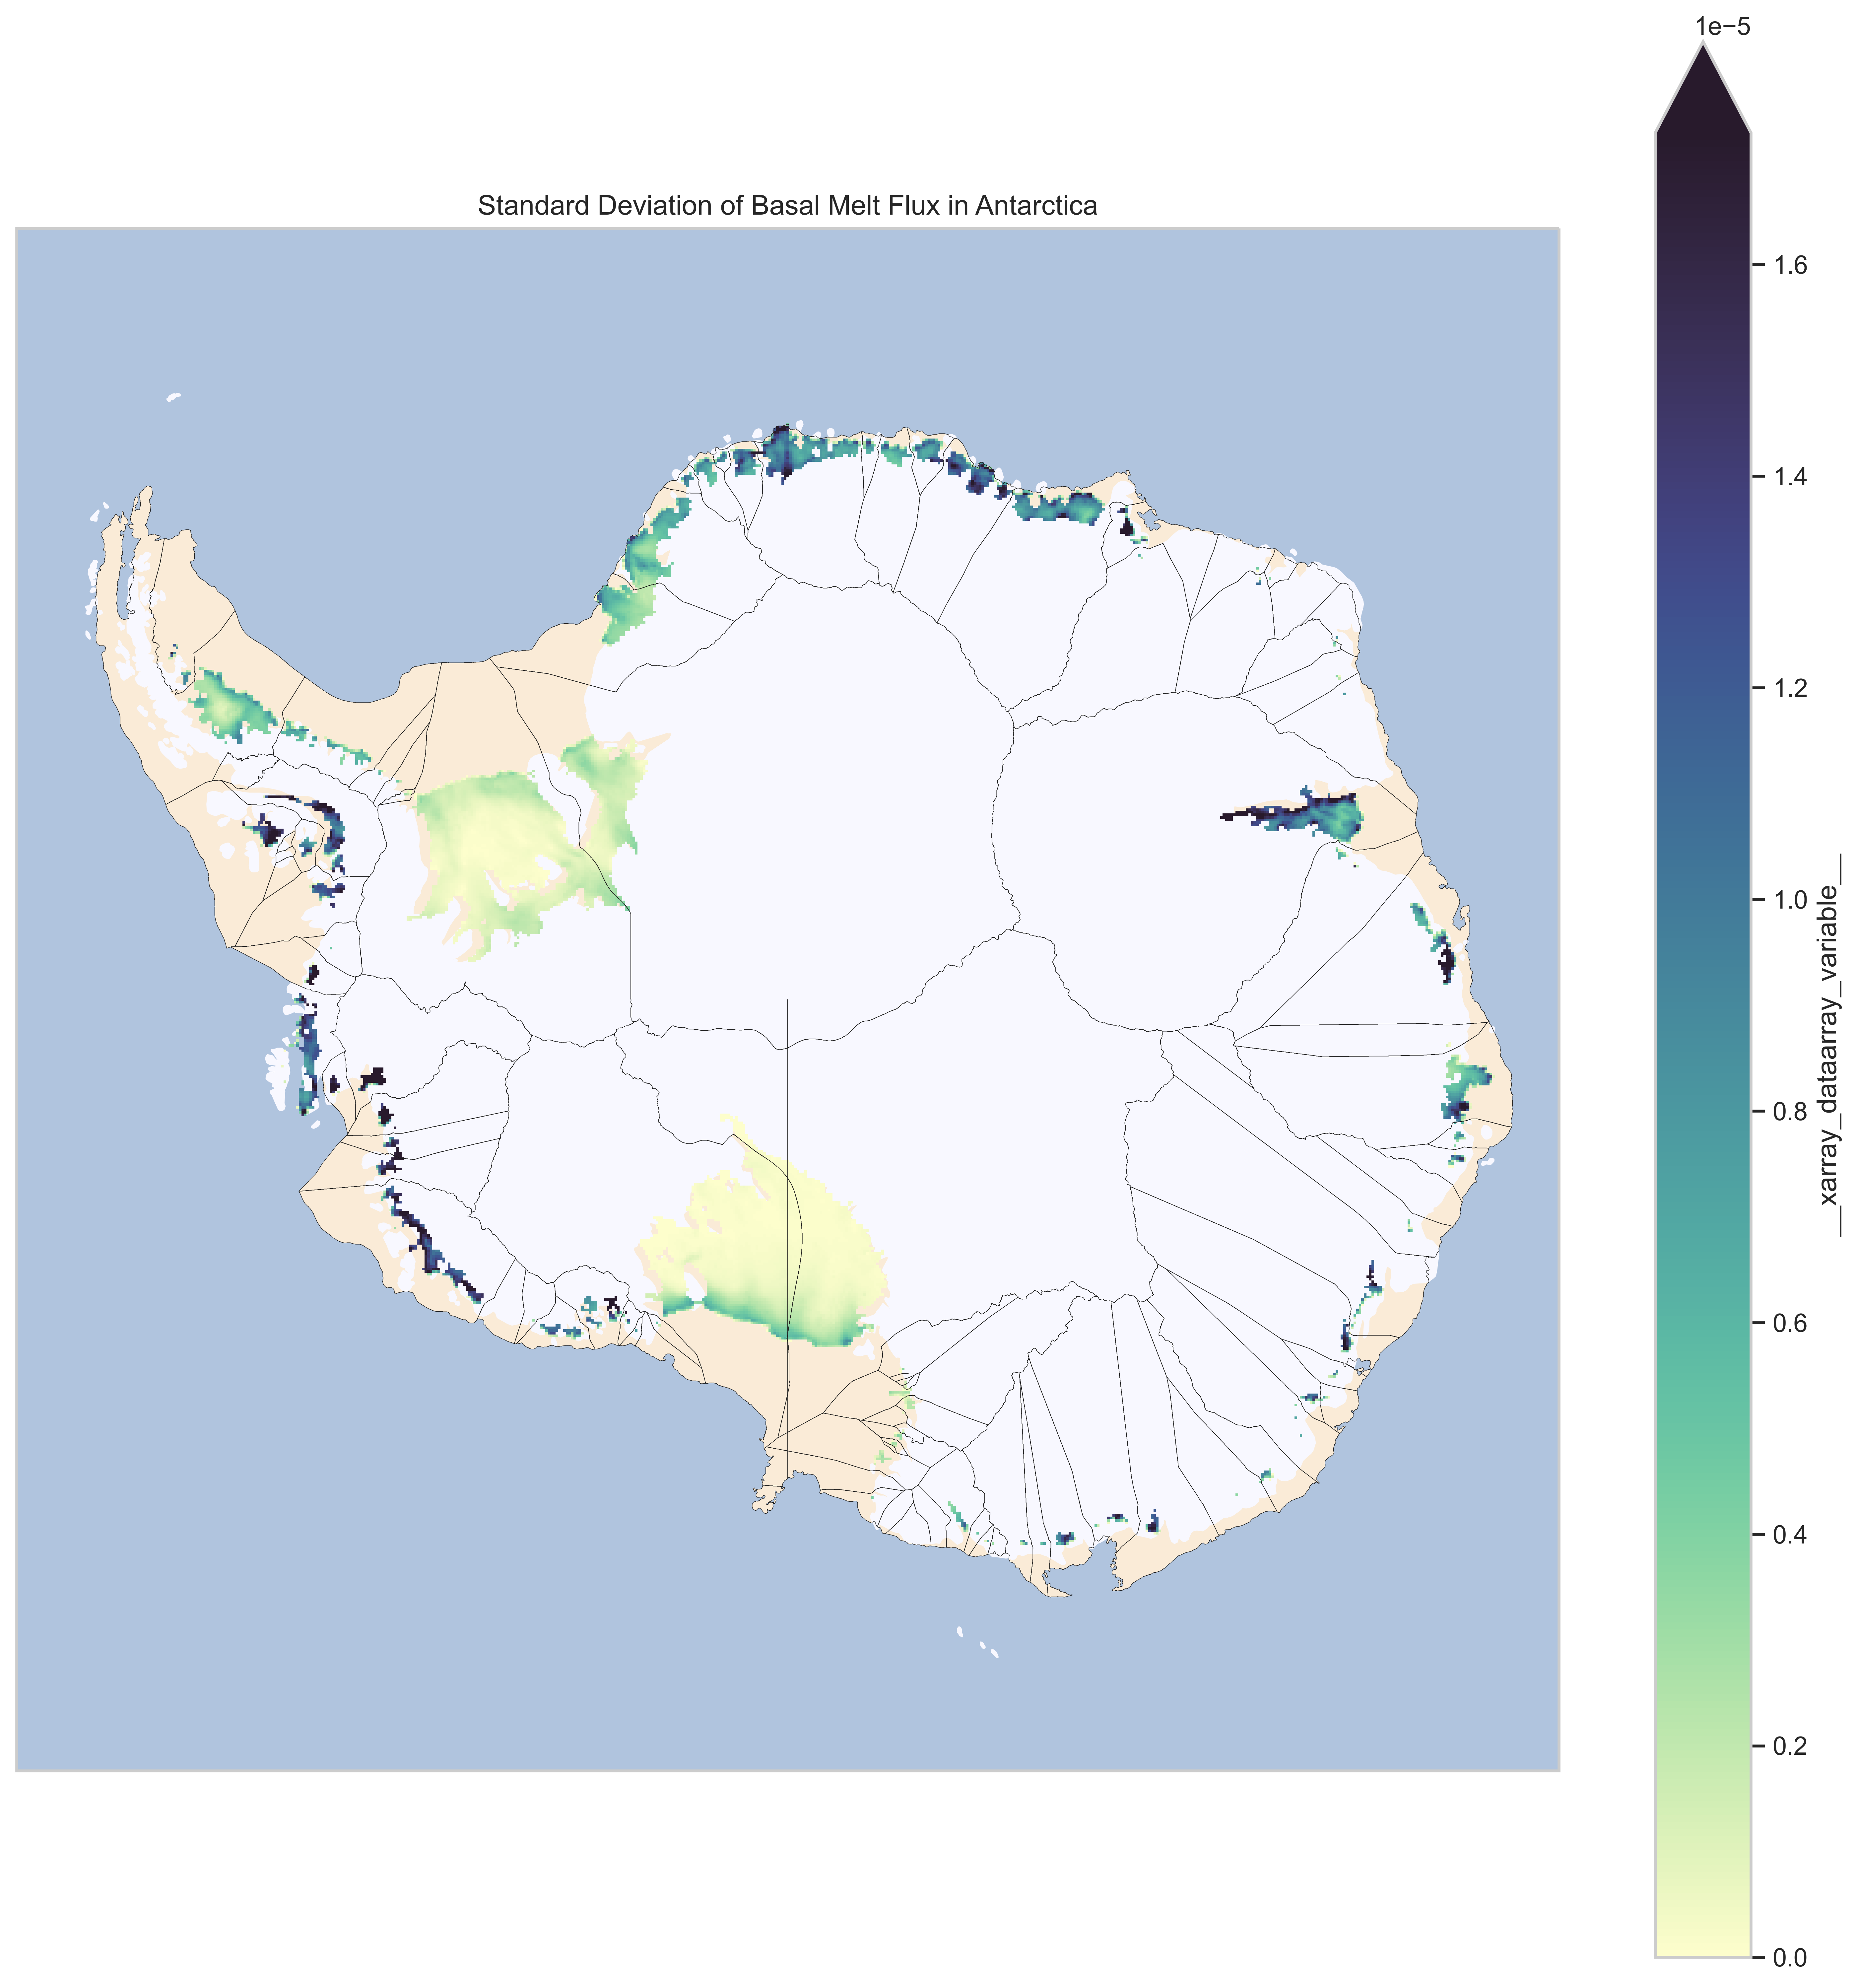

In [23]:
# Plot boundaries

sns.set_theme(style="whitegrid")

# dfs_issues.plot(ax=ax, zorder=2, label=label, markersize=50, marker='*', column='issue', categorical=True, cmap=cmap_new, legend=True)

plt.figure(figsize=(15,15),dpi=500)
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=4)
data_tstd.where(data_tstd>0).plot(vmin=vmin_data_tstd, vmax=vmax_data_tstd, cmap=cmocean.cm.deep,zorder=3)

ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
plt.title('Standard Deviation of Basal Melt Flux in Antarctica');

In [9]:
def clip_data(total_data, basin):
    """
    Clip the map to a specific domain
    data: input data (xarray DataArray)
    domain: domain name (string), as defined in the ice shelf geometry file (icems)
    """
     # TODO: Include a step here to convert from domain name string to the domain index number used in the ice shelf geometry file
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

In [10]:
sorrmv21_draft_mean.rio.write_crs("epsg:3031",inplace=True);
#data_tstd.rio.write_crs("epsg:3031",inplace=True);
norm_eofs.rio.write_crs("epsg:3031",inplace=True);
eofs.rio.write_crs("epsg:3031",inplace=True);


NameError: name 'sorrmv21_draft_mean' is not defined

extracting data for catchment Abbot


NameError: name 'sorrmv21_draft_mean' is not defined

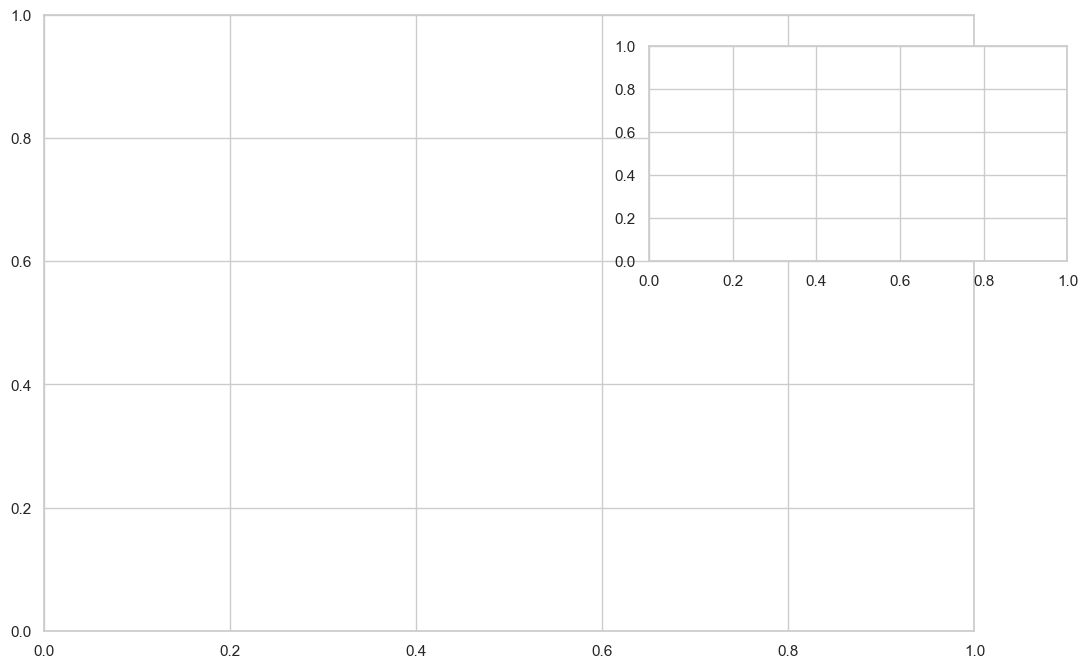

In [11]:
IMBIEregions = range(6,33)
iceShelfRegions = range(33,133)

sns.set_theme(style="whitegrid")

for i in iceShelfRegions:
    fig, ax = plt.subplots(1, 1, figsize=[12, 8])
    axins = ax.inset_axes([0.65, 0.6, 0.45, 0.35])
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    melt_std = clip_data(data_tstd, i)
    z = clip_data(sorrmv21_draft_mean, i)
    ax.scatter(melt_std, z,color='r',s=1)
    ax.set_xlabel('Standard Deviation of Freshwater Flux Variability (kg/m2/s)')
    #ax.set_xlabel('Freshwater Flux (kg/m2/s)')
    ax.set_ylabel('Draft (m)')
    # ax.set_ylim(2000,0)
    ax.set_title(icems.name[i])
    icems[33:133].plot(ax=axins,linewidth=0.3)
    icems.loc[[i],'geometry'].plot(ax=axins,color='r')
    plt.savefig(main_dir / "reports/figures/interim/sorrm-std-dev-draft/{}_sorrm_std-dev-draft.png".format(icems.name[i]))
    print("saved fig {}.png".format(icems.name[i]))
    plt.close()
    del melt_std, z
    print('deleted interim variables')
    gc.collect()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


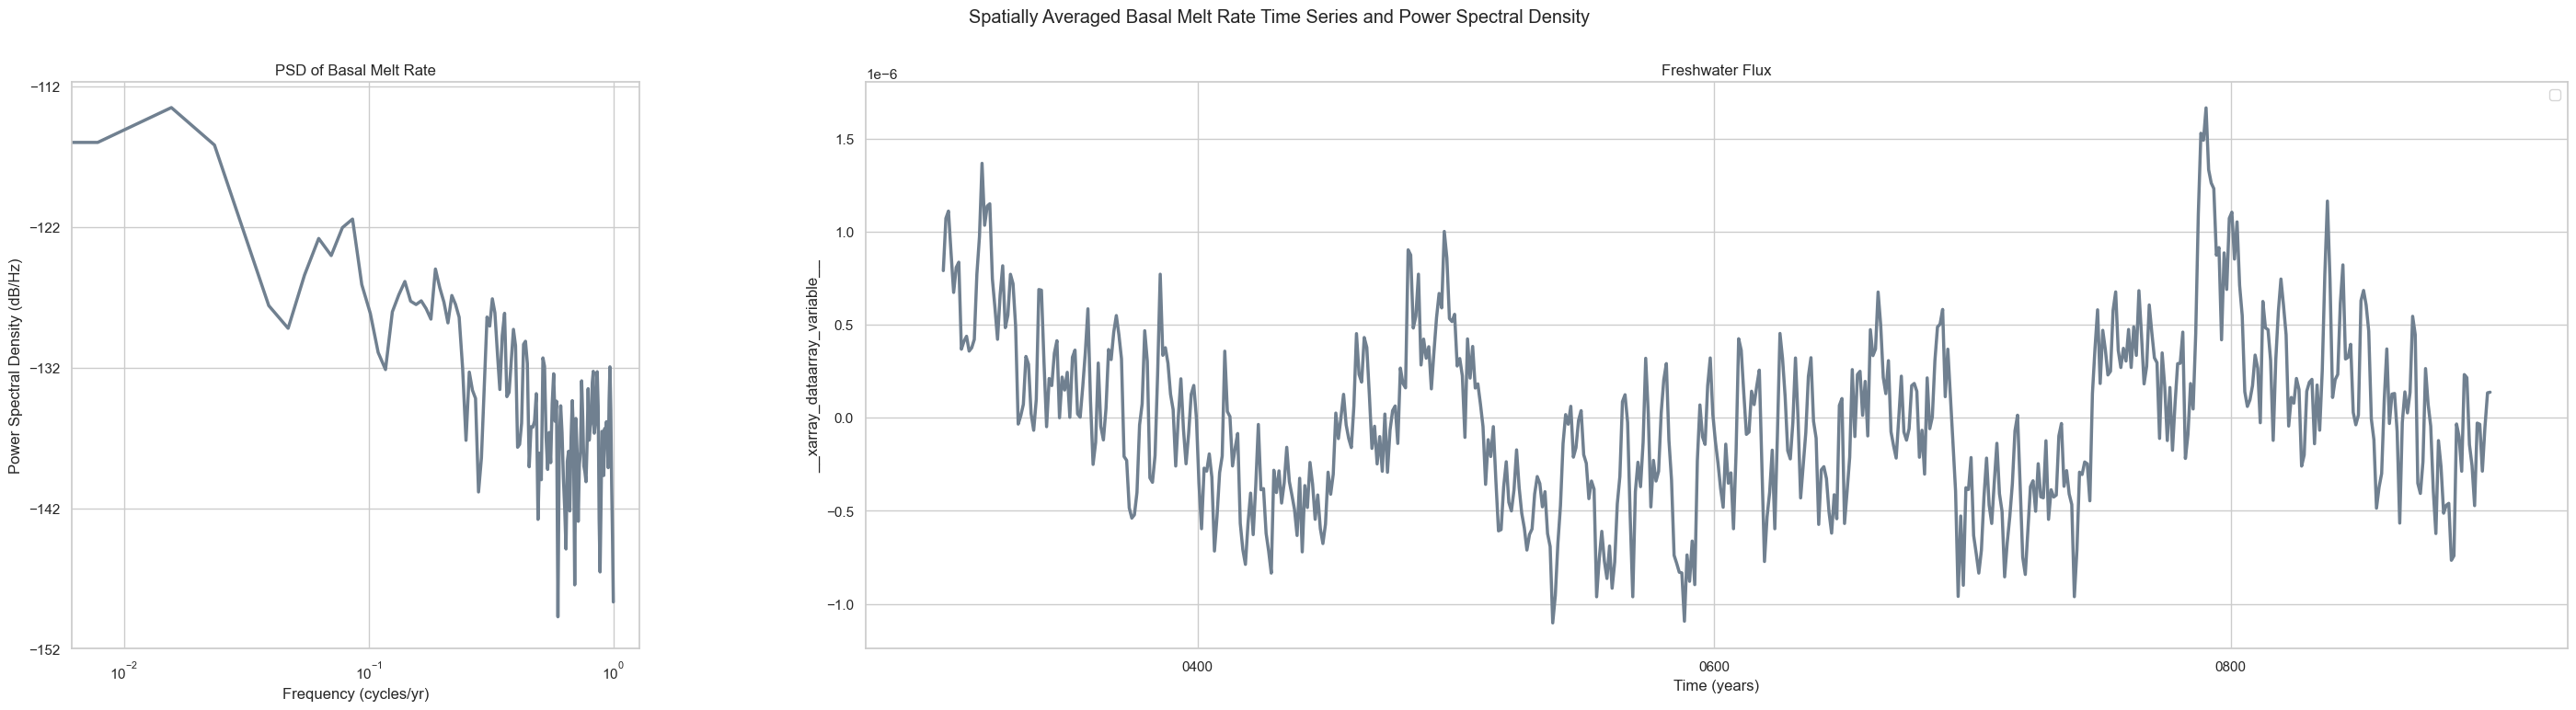

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(35, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(data_ts, lw=2.5, color='slategray');
axs[0].set_xlabel('Frequency (cycles/yr)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Rate')

data_ts.plot(ax=axs[1], lw=2.5, color='slategray')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Freshwater Flux')

plt.legend()
fig.suptitle('Spatially Averaged Basal Melt Rate Time Series and Power Spectral Density')
plt.show()

In [13]:
%%time

# Non-normalized variability decomposition 
model = EOF(data)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()
pcs_eig = model.pcs(1)

# Normalized variability decomposition 
norm_model = EOF(data_norm)
norm_model.solve()
norm_eofs = norm_model.eofs()
norm_pcs = norm_model.pcs()
norm_nmodes = norm_model.n_modes
norm_varexpl = norm_model.explained_variance_ratio()
norm_pcs_eig = norm_model.pcs(1)
norm_eofs_eig = norm_model.eofs(1)
norm_eofs_sng = norm_model.eofs(2)
norm_pcs_sng = norm_model.pcs(2)
norm_varexpl_values = norm_model.explained_variance()

CPU times: user 1min 6s, sys: 21.7 s, total: 1min 28s
Wall time: 17.5 s


fig, ax = plt.subplots(1, 1, figsize=[12, 8])
axins = ax.inset_axes([0.65, 0.6, 0.45, 0.35])
print('extracting data for catchment {}'.format(icems.name.values[i]))
melt_std = clip_data(data_tstd, i)
z = clip_data(sorrmv21_draft_mean, i)
ax.scatter(melt_std, z,color='r',s=1)

extracting data for catchment Filchner-Ronne


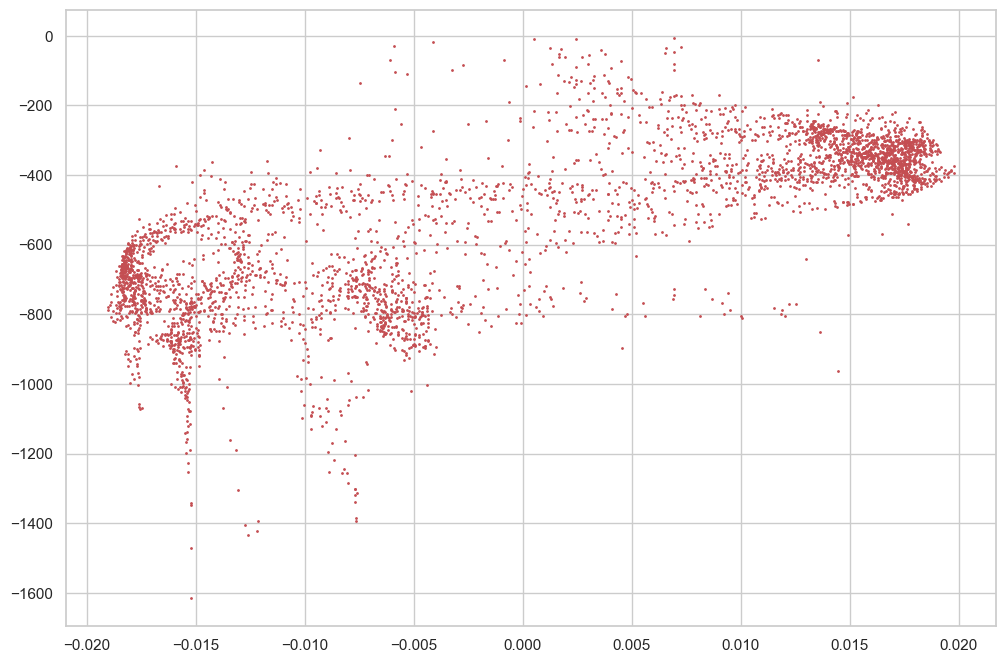

In [24]:

sns.set_theme(style="whitegrid")

for i in iceShelfRegions:
    for mode in modes_to_plot:
        fig, ax = plt.subplots(3, 1, figsize=[12, 8])
        axins = ax.inset_axes([0.65, 0.6, 0.45, 0.35])
print('extracting data for catchment {}'.format(icems.name.values[i]))
melt_std = clip_data(norm_eofs[:,:,0], i)
z = clip_data(sorrmv21_draft_mean, i)
ax.scatter(melt_std, z,color='r',s=1)

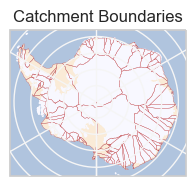

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plot boundaries

plt.figure(figsize=(5,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

In [ ]:
iceShelfRegions = range(33,133)

sns.set_theme(style="whitegrid")
#fig, ax = plt.subplots(1, 1, figsize=[15, 15],subplot_kw={'projection': ccrs.SouthPolarStereo()})

for i in iceShelfRegions:
    z = clip_data(sorrmv21_draft_mean, i)
    z_min = z.min()
    fig, axs = plt.subplots(2,3, figsize=[15, 10]) # Plot 6 EOFs vs. draft for each ice shelf.
    axs=axs.ravel()
    fig.suptitle('{}'.format(icems.name.values[i]),fontsize ='large')
    for mode in range(6):
        #mlt_eof = clip_data(eofs[:,:,mode], i)
        mlt_norm_eof = clip_data(norm_eofs[:,:,mode], i)
        #axs[mode].scatter(mlt_eof, z, color='r', s=0.75, label = "EOF {}".format(mode))
        axs[mode].scatter(mlt_norm_eof, z, color='g', s=0.75, label = "NORM_EOF {}".format(mode))
        axs[mode].set_ylim(z_min,0) # Specified for consistency across plots, some catchments are not as deep as others
        axs[mode].xaxis.set_tick_params(labelsize=15)
        axs[mode].yaxis.set_tick_params(labelsize=15)
        # axs[mode].text(-0.04, 1.08, label, transform=axs[mode].transAxes ,fontweight='bold', va='top')
        #axins = inset_axes(axs[mode],width="30%", height="30%", loc="upper right", 
        #                    axes_class=cartopy.mpl.geoaxes.GeoAxes, 
        #                    axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
        #icems[33:133].plot(ax=axins,linewidth=0.6,color='lightsteelblue')
        #axins.coastlines(resolution='10m',linewidth=0.5)
        #icems.loc[[i],'geometry'].plot(ax=axins,color='r',linewidth=0.5) 
        #axins.set_axis_off();
        axs[mode].grid(alpha=0.75)
        axs[mode].legend()
    plt.savefig(main_dir / "reports/figures/interim/sorrm_xplore/norm_eof_vs_draft/{}_eof-vs-draft.png".format(icems.name[i]))
    print("saved fig {}.png".format(icems.name[i]))
    plt.close()
    del mlt_norm_eof, z, z_min
    print('deleted interim variables')
    gc.collect()


In [38]:
# Cumulative variance captured
Fv_cs = varexpl.cumsum()
Fvn_cs = norm_varexpl.cumsum()

In [48]:
F_vn_eofs = norm_eofs_eig
F_vn_pcs = norm_pcs_eig

NameError: name 'F_vn_pcs' is not defined

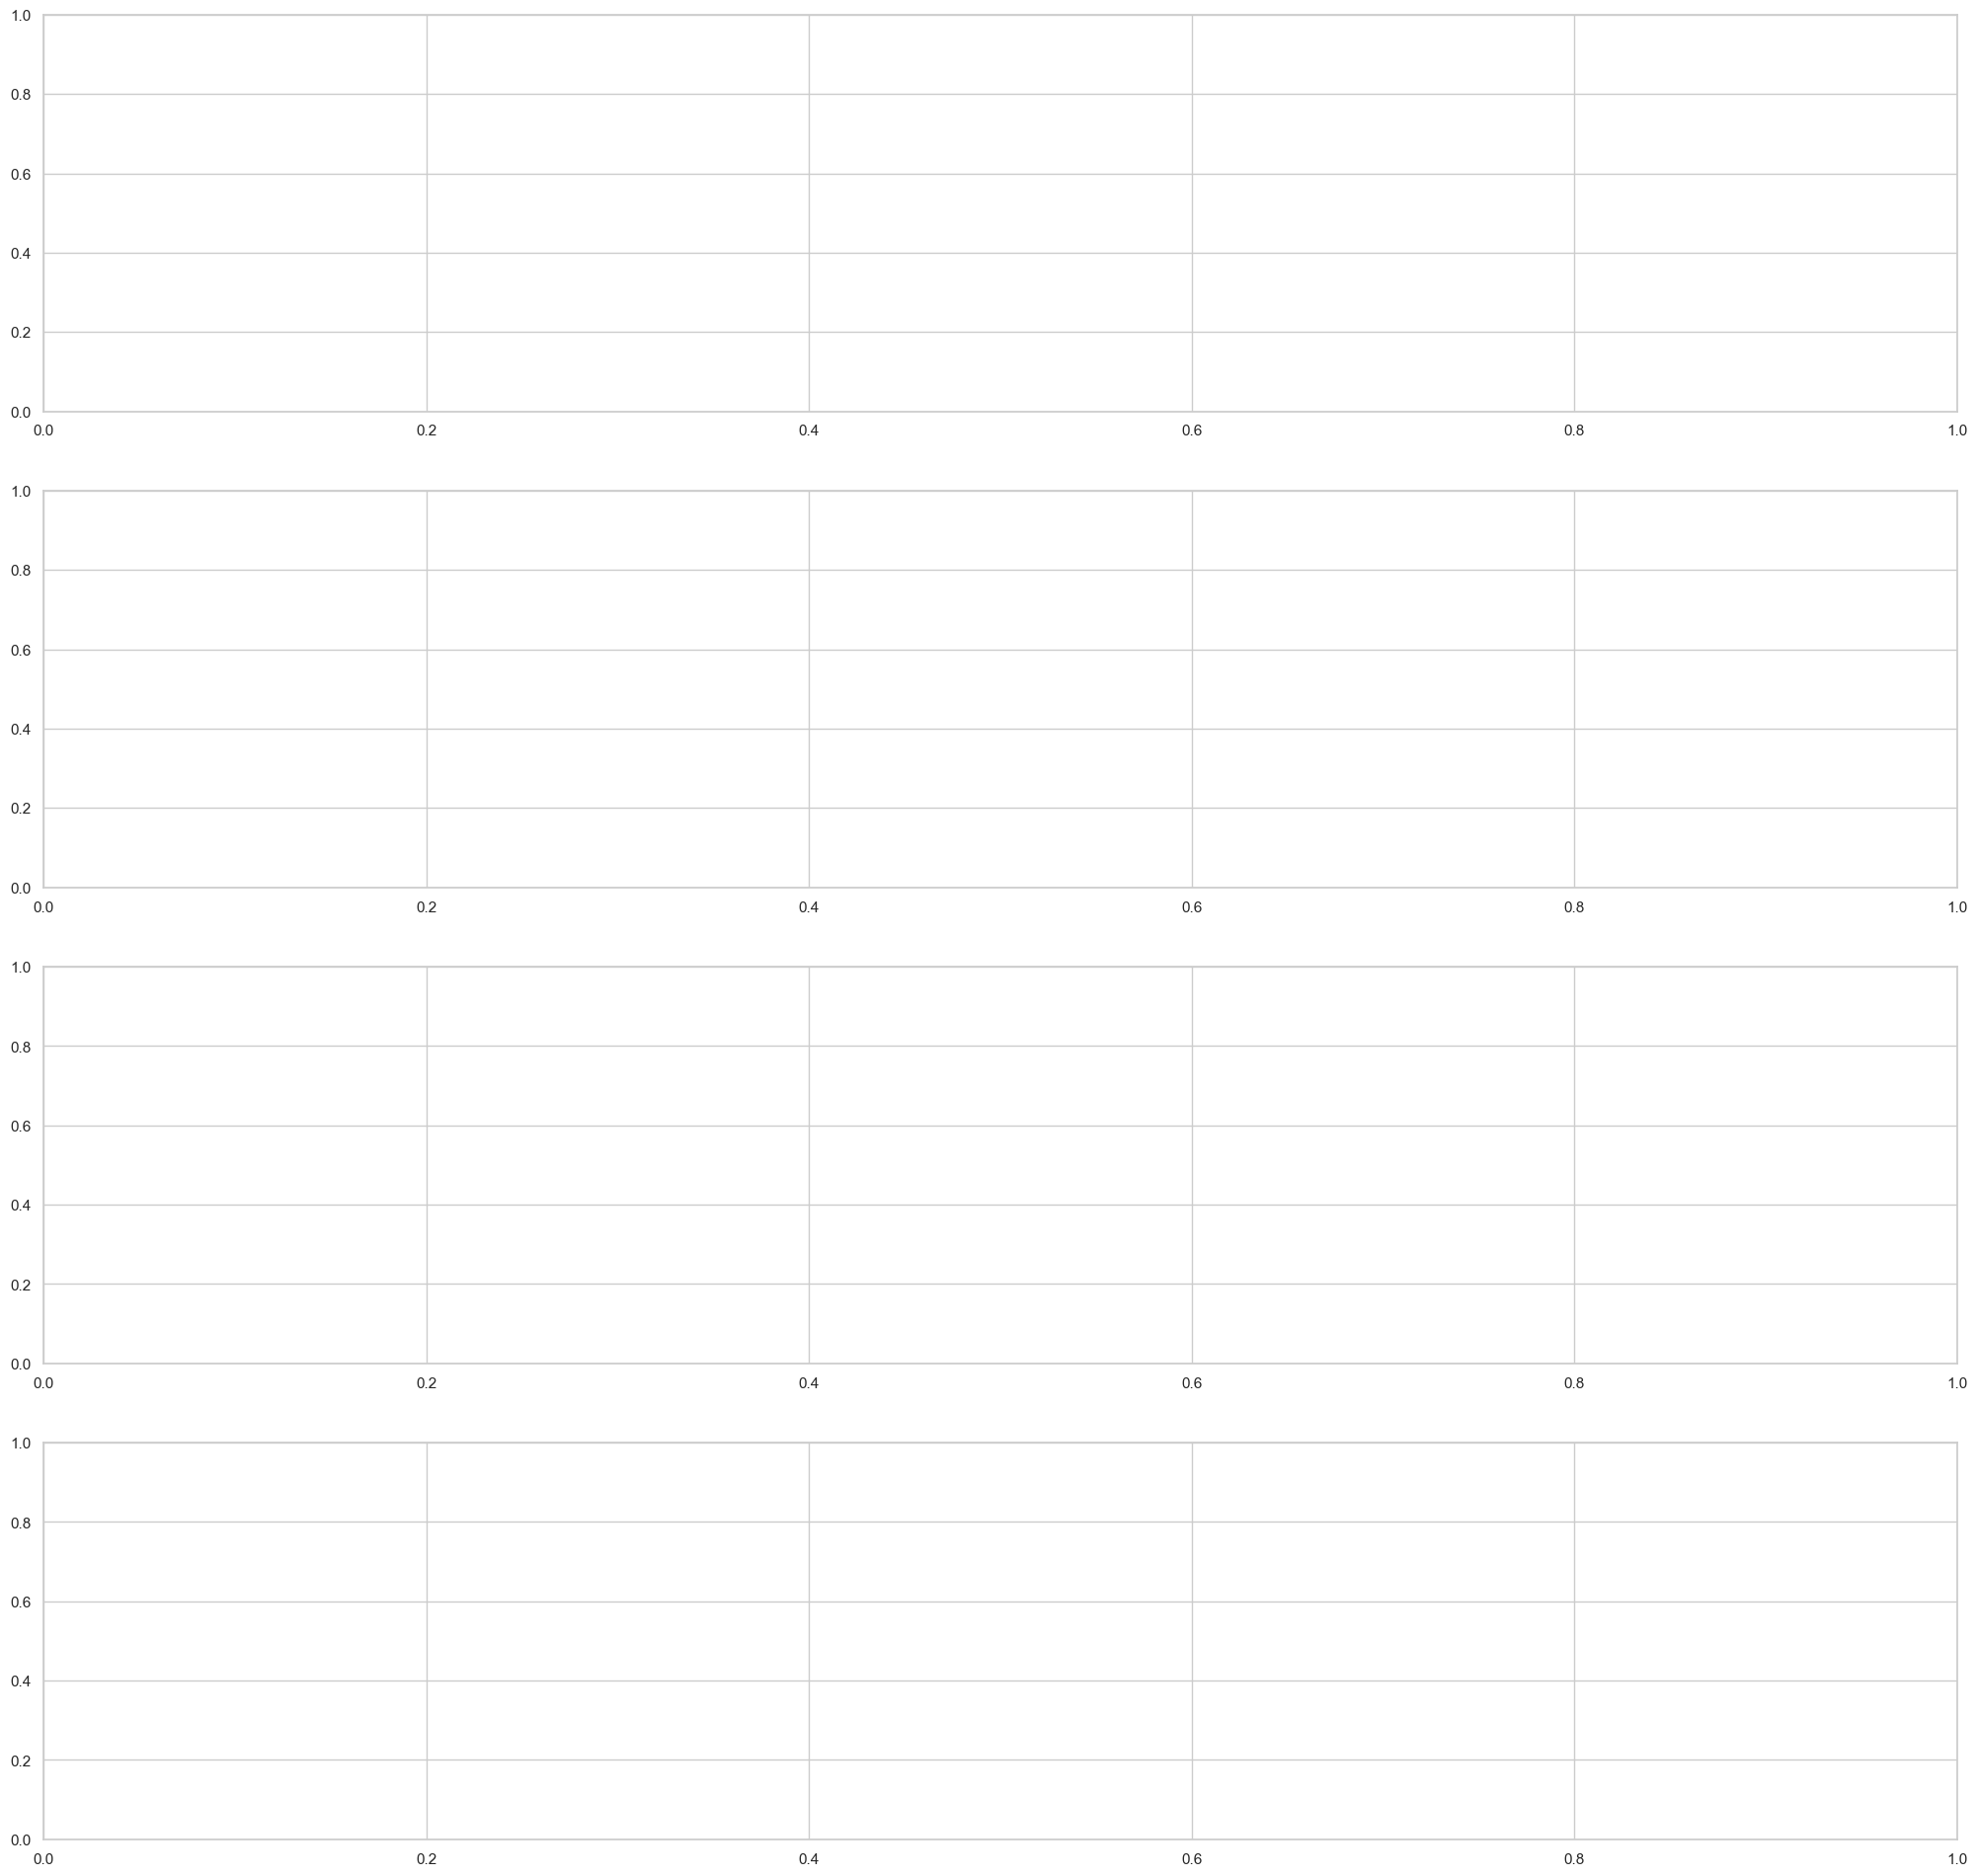

In [14]:
plt.subplots(4,1, figsize=(25,24))
plt.subplot(411)
F_vn_pcs[:,0].plot(color='slategray', lw=2.5)
plt.title('PC Mode 1')
plt.xlabel('')
plt.ylabel('SD Units')

plt.subplot(412)
F_vn_pcs[:,1].plot(color='slategray', lw=2.5)
plt.title('PC Mode 2')
plt.xlabel('')
plt.ylabel('SD Units')

plt.subplot(413)
F_vn_pcs[:,3].plot(color='slategray', lw=2.5)
plt.title('PC Mode 3')
plt.xlabel('')
plt.ylabel('SD Units')

plt.subplot(414)
F_vn_pcs[:,4].plot(color='slategray', lw=2.5)
plt.title('PC Mode 4')
plt.xlabel('Time (Model Simulation Years)')
plt.ylabel('SD Units')

In [15]:
plt.figure(figsize=(25,8))
for i in range(10,20):
    F_vn_pcs[:,i].coarsen(time=200).mean().plot()

NameError: name 'F_vn_pcs' is not defined

<Figure size 2500x800 with 0 Axes>

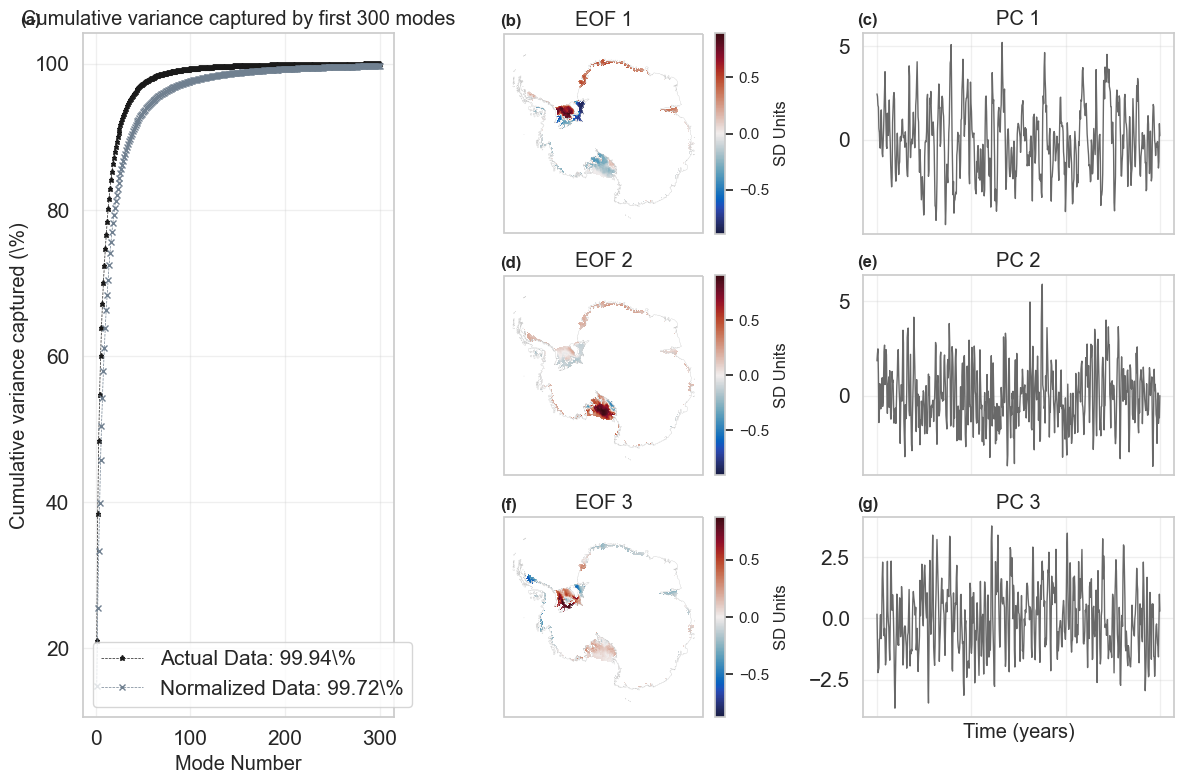

In [73]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data

nmodes_plot = 3 # Number of modes to plot

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

varpanel = '(a)'
eofpanels = ['(b)','(d)','(f)']
pcpanels = ['(c)','(e)','(g)']

yr_length = range(0,125)
yrs_plot = np.repeat(yr_length, 12)

#sns.set_theme()
sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(12,8))
gs = GridSpec(nmodes_plot,3,width_ratios=[1.25,1,1.25])
axbig = fig.add_subplot(gs[:, 0])
ax0 = [fig.add_subplot(gs[i, 1],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 2]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    F_vn_eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a0.set_title('EOF {}'.format(i+1), fontsize='large')
    a0.text(-0.02, 1.1, eofpanels[i], transform=a0.transAxes ,fontweight='bold', va='top')
    #a1.set_ylim(-3,3)
    #a1.set_xlim(0,1500)
    a1.plot(F_vn_pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')
    a1.yaxis.set_tick_params(labelsize=15)
    a1.xaxis.set_tick_params(labelsize=15)
    a1.set_title('PC {}'.format(i+1), fontsize='large')
    a1.tick_params(labelbottom=False, left=False, grid_alpha=0.3)
    a1.text(-0.02, 1.1, pcpanels[i], transform=a1.transAxes ,fontweight='bold', va='top')

a1.set_xlabel('Time (years)', fontsize='large');

m = 300
xvar = np.linspace(1,m,m)
axbig.plot(xvar,Fv_cs[:m]*100, 'k*--', lw=0.5,markersize=3.75,
         label='Actual Data: {:.2f}\%'.format(varexpl[:m].sum().values*100))

axbig.plot(xvar,Fvn_cs[:m]*100,'x--', lw=0.5,markersize=3.75,
         label='Normalized Data: {:.2f}\%'.format(norm_varexpl[:m].sum().values*100),color='slategray')
axbig.set_ylabel('Cumulative variance captured (\%)', fontsize='large')
axbig.set_xlabel('Mode Number', fontsize='large')
axbig.yaxis.set_tick_params(labelsize=15)
axbig.xaxis.set_tick_params(labelsize=15)
axbig.set_title('Cumulative variance captured by first {} modes'.format(m), fontsize='large');
axbig.tick_params(labelbottom=True, left=False, grid_alpha=0.3)
axbig.legend(fontsize="15");
axbig.text(-0.2, 1.03, '(a)', transform=axbig.transAxes ,fontweight='bold', va='top')


plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig.tight_layout()

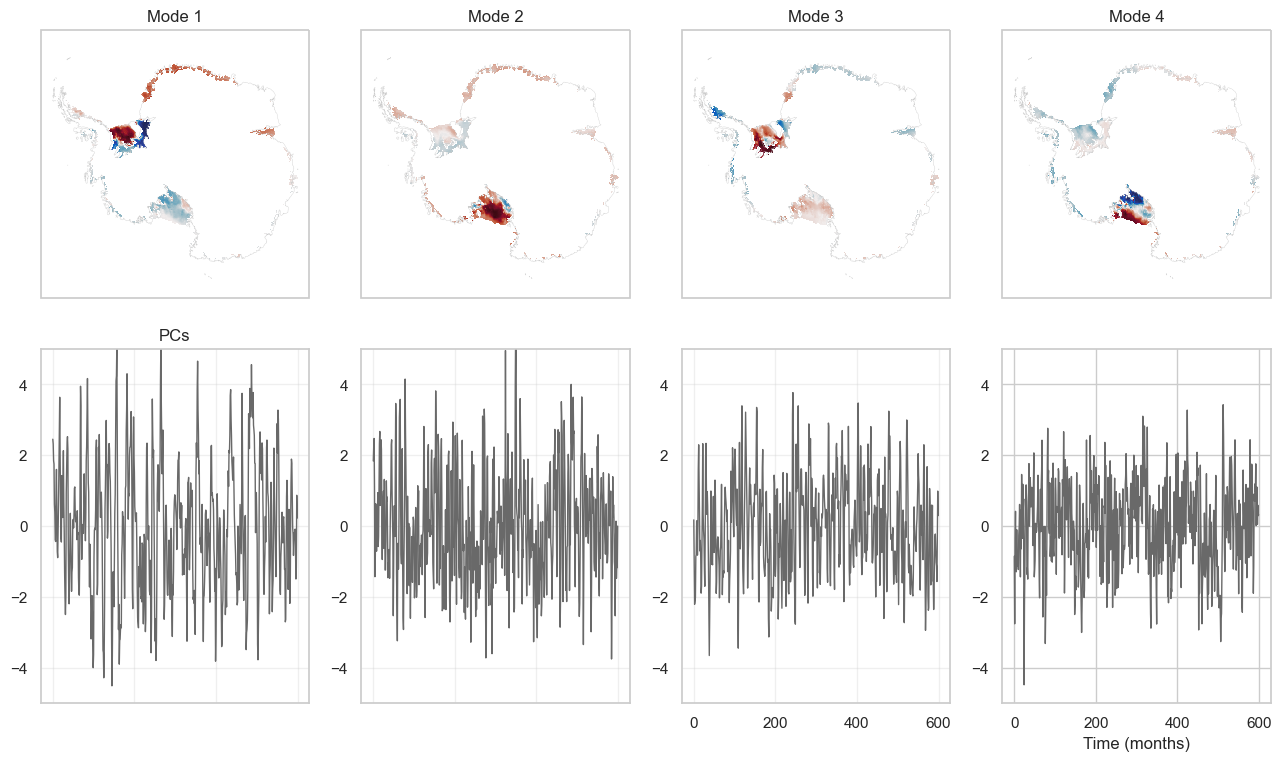

In [88]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data

nmodes_plot = 4 # Number of modes to plot

yr_length = range(0,125)
yrs_plot = np.repeat(yr_length, 12)

#sns.set_theme()
sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(13,8))
gs = GridSpec(2,nmodes_plot,width_ratios=[1,1,1,1])
ax0 = [fig.add_subplot(gs[0, i],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[1, i]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    F_vn_eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=False)#,
                            #cbar_kwargs={'orientation': 'vertical',
                            #             'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.set_ylim(-5,5)
    a1.plot(F_vn_pcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')

a1.set_xlabel('Time (months)');

# fig.suptitle("Leading {} modes of normalized model output".format(nmodes_plot))
# Remove x axis for time series plots on top
ax1[0].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
ax1[1].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
ax1[2].tick_params(labelbottom=True, left=False, grid_alpha=0.3)

ax0[0].set_title("Mode 1");
ax0[1].set_title("Mode 2");
ax0[2].set_title("Mode 3");
ax0[3].set_title("Mode 4");
ax1[0].set_title("PCs");

plt.tight_layout()

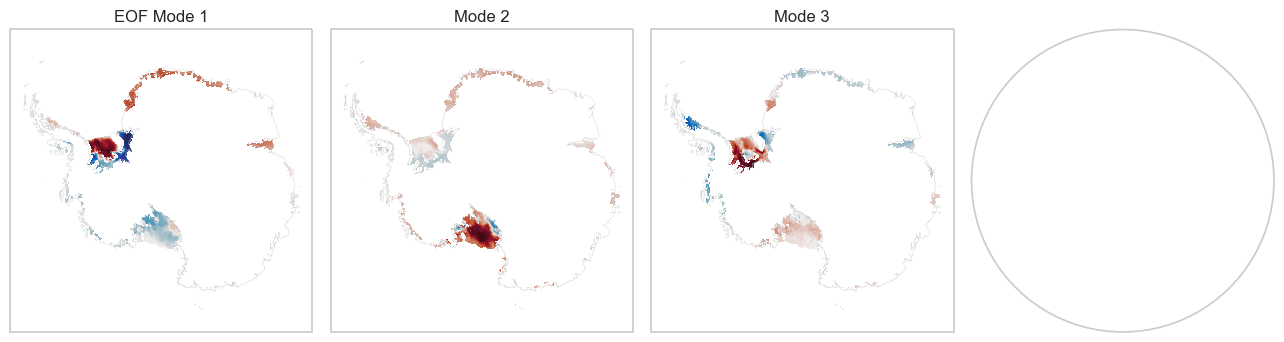

In [84]:
# Plot figure
# Figure: EOF modes from decomposition of normalized model variability data

nmodes_plot = 4 # Number of modes to plot

yr_length = range(0,125)
yrs_plot = np.repeat(yr_length, 12)

#sns.set_theme()
sns.set_theme(style="whitegrid")
fig=plt.figure(figsize=(13,8))
gs = GridSpec(1,nmodes_plot,width_ratios=[1,1,1,1])
ax0 = [fig.add_subplot(gs[0, i],projection=crs) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    F_vn_eofs.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=False)#,
                            #cbar_kwargs={'orientation': 'vertical',
                            #             'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')

a1.set_xlabel('Time (months)');

# fig.suptitle("Leading {} modes of normalized model output".format(nmodes_plot))
# Remove x axis for time series plots on top
ax1[0].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
ax1[1].tick_params(labelbottom=False, left=False, grid_alpha=0.3)
ax1[2].tick_params(labelbottom=True, left=False, grid_alpha=0.3)

ax0[0].set_title("EOF Mode 1");
ax0[1].set_title("Mode 2");
ax0[2].set_title("Mode 3");
ax1[0].set_title("PCs");

plt.tight_layout()

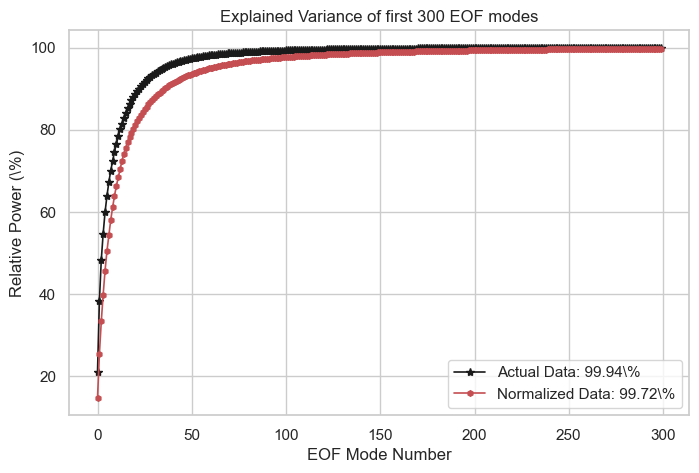

In [83]:
# Plot figure
# Figure: Relative power of m EOFs

m = 300
sns.set_theme(style="whitegrid")

#ax = plt.subplot(111)

# Change figsize parameters to adjust size of all elements at once - might not be optimal. 
# Commented code snippets allow for better control
ax = plt.figure(figsize=(8,5))
plt.plot(range(m),Fv_cs[:m]*100, 'k*-', lw=1.2,
         label='Actual Data: {:.2f}\%'.format(varexpl[:m].sum().values*100))
plt.plot(range(m),Fvn_cs[:m]*100, 'rh-', lw=1.2,markersize=4,
         label='Normalized Data: {:.2f}\%'.format(norm_varexpl[:m].sum().values*100))
plt.ylabel('Relative Power (\%)')
plt.xlabel('EOF Mode Number')
plt.title('Explained Variance of first {} EOF modes'.format(m));
plt.legend();


#ax.title.set_fontsize(18)
#ax.xaxis.label.set_fontsize(18)
#ax.yaxis.label.set_fontsize(18)


In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 10
t_length = norm_pcs.shape[0]

# Define random number generator 
#rng = np.random.default_rng(2021)
#random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j) in line 26

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,norm_pcs.shape[0],norm_pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = norm_pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        #random_phases = np.exp(np.random.vonmises(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

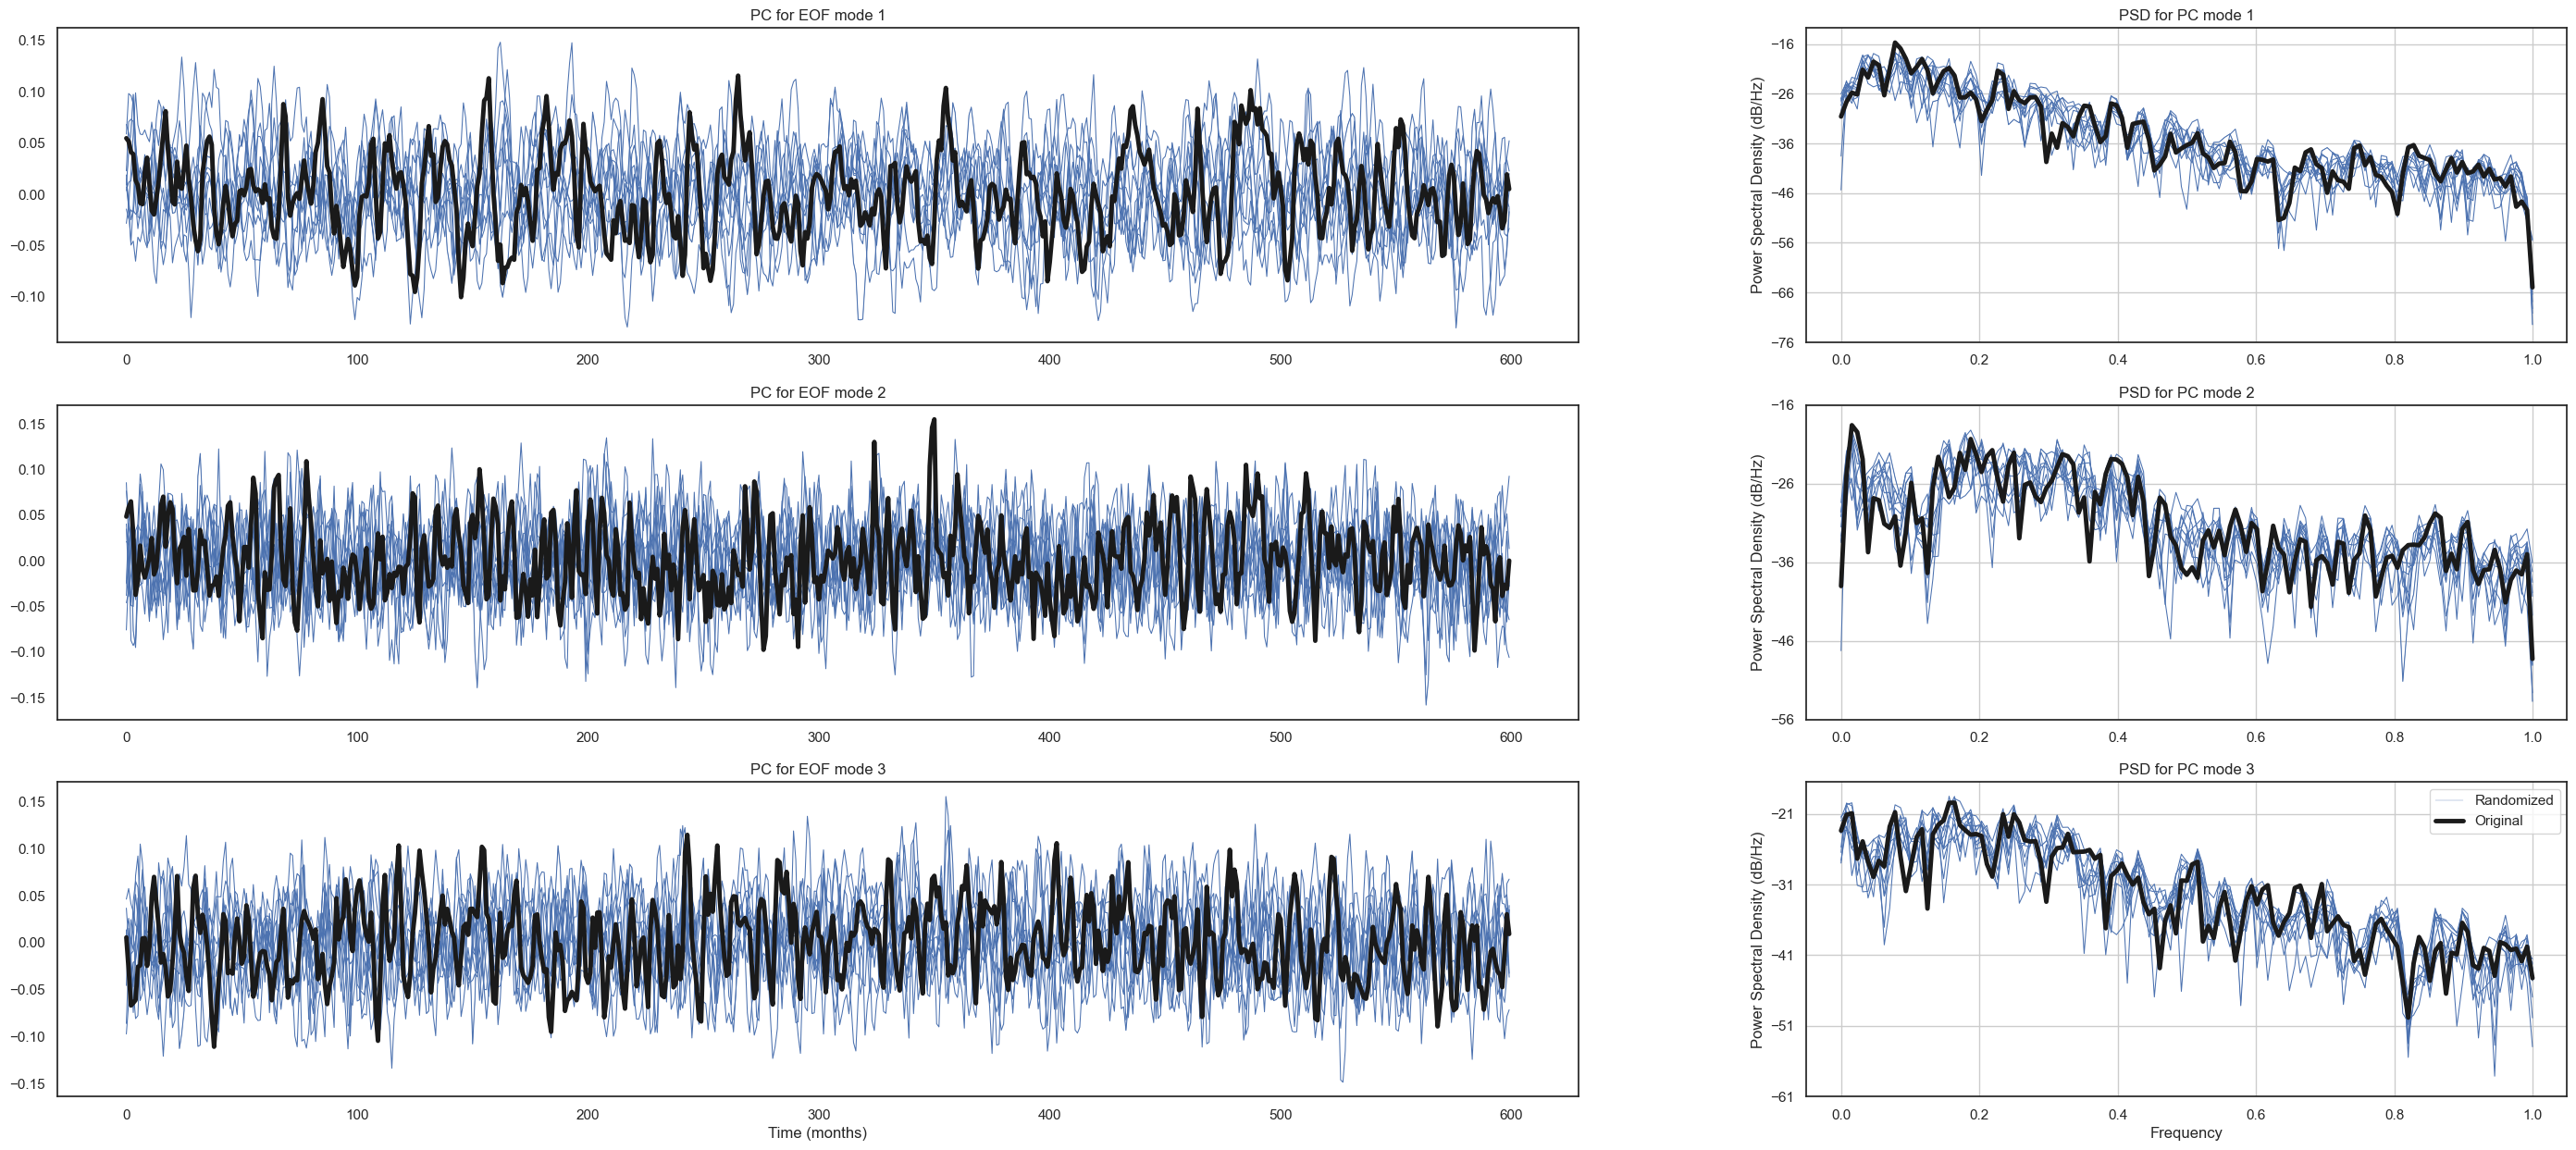

In [163]:
# Diagnostic plot of generated PCs

nmodes_plot = 3 # Number of modes to plot
nrealizations_to_plot = 10 # to be lesser than absolute total number, defined in the Fourier randomization step

sns.set_theme(style="white")
fig=plt.figure(figsize=(35,15))

gs = GridSpec(nmodes_plot, 2, width_ratios=[4, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0,a1) in enumerate(zip(ax0,ax1)):
    for n_realization in range(0,nrealizations_to_plot):
        a0.plot(new_fl[n_realization,:,i],color='b', linewidth=0.75)
        a1.psd(new_fl[n_realization,:,i],color='b', linewidth=0.75)
        #a1.set_xscale('log')
    a0.plot(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a1.psd(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a0.plot(norm_pcs[:,i],color='k', linewidth=3.5,label='Original')
    a1.psd(norm_pcs[:,i],color='k', linewidth=3.5,label='Original')
    a0.set_title('PC for EOF mode {}'.format(i+1))
    a1.set_title('PSD for PC mode {}'.format(i+1))
    a1.set_xlabel('')

a0.set_xlabel('Time (months)')
a1.set_xlabel('Frequency')
plt.legend();

In [12]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data


def generate_data(n_realization,mode,mode_skip):
    # mode can be any int in (1,nmodes), for cases 
    # when dimensionality reduction is preferred on the reconstructed dataset
    flux_reconstr = norm_model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [ ]:
# Generate dataset realizations

## Standard EOF/PCA implementation
# Can use the xeofs-rand package, or directly generate using sklearn PCA.

for i in range(n_realizations):
    flux_reconstr = generate_data(i, 600, 1)
    flux_reconstr = (flux_reconstr*da_tstd)+da_tmean
    flux_reconstr = flux_reconstr.rename('rec{}'.format(n_realizations))
    flux_reconstr.to_netcdf(main_dir / DIR_interim / 'reconstructions/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_RECONSTR_{}.nc'.format(i))
    print('reconstructed realization # {}'.format(i))

In [132]:
rec1 = xr.open_dataset(main_dir / DIR_interim / 'reconstructions/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_RECONSTR_1.nc')
rec1

<xarray.Dataset>
Dimensions:      (time: 600, x: 601, y: 601)
Coordinates:
  * time         (time) object 0301-07-01 17:00:00.000001 ... 0900-07-01 17:0...
  * x            (x) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.99e+06 3e+06
  * y            (y) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.99e+06 3e+06
    lat          (y, x) float64 ...
    lon          (y, x) float64 ...
    month        (time) int64 ...
    spatial_ref  int64 ...
Data variables:
    rec5         (time, y, x) float64 ...

In [133]:
flux_clean = data
rec0 = xr.open_dataset(main_dir / DIR_interim / 'reconstructions/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_RECONSTR_0.nc')
rec0 = rec0.rec5

rec1 = xr.open_dataset(main_dir / DIR_interim / 'reconstructions/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_RECONSTR_1.nc')
rec1 = rec1.rec5

rec2 = xr.open_dataset(main_dir / DIR_interim / 'reconstructions/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_RECONSTR_2.nc')
rec2 = rec2.rec5

rec3 = xr.open_dataset(main_dir / DIR_interim / 'reconstructions/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_RECONSTR_3.nc')
rec3 = rec3.rec5

rec4 = xr.open_dataset(main_dir / DIR_interim / 'reconstructions/SORRMv21_300-900_DETREND_DESEASONALIZE_DEDRAFT_RESAMPLE_RECONSTR_4.nc')
rec4 = rec4.rec5

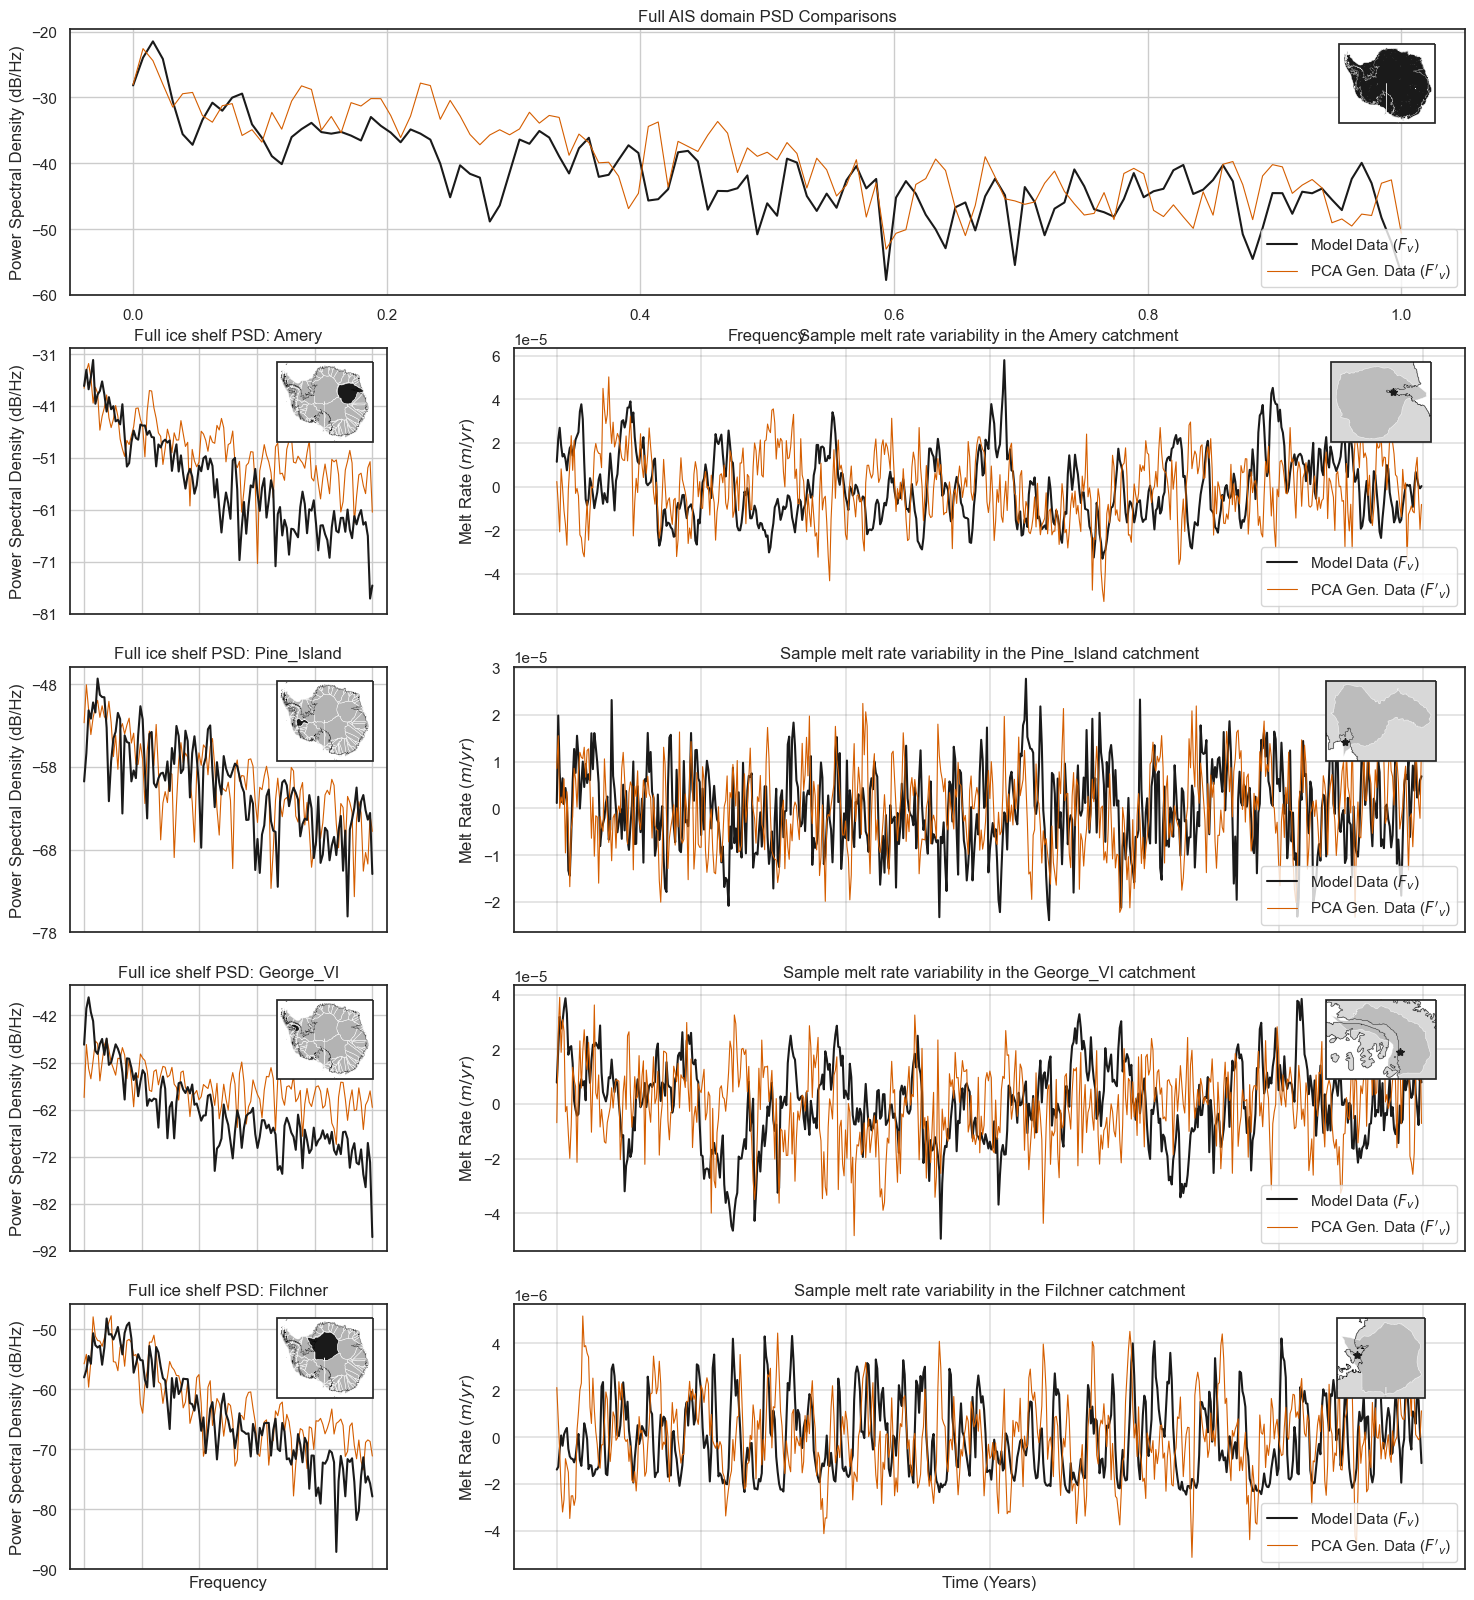

In [145]:
#catchments = np.array([1,27,28,61,70,83,94,71,22])
#basins = catchments+33

#basins = [34, 55, 60, 61, 94, 103]
#basins = [55,94]
#basins = [34, 60]
#grid_points = np.array(([85,105], [115,45], [4,45],[21,56], [11,10], [34,95]))
#grid_points = np.array(([115,45],[11,10]))
#grid_points = np.array(([85,105],[4,45]))

basins = [34,94,60,55,94]
# Choose grid points based on dataset indices. Can find these using data.x and data.y dimension arrays.
# Locations here have been selected based on performance of model simulation data at these points, 
# given also the variance between them (in terms of temporal scale of variability)
grid_points = np.array(([85,105], [11,10],[15,44], [100,40]))

#basins = np.array([34, 60, 94, 55])
# [2,3,4,5] = [Antarctica, Peninsula, West Antarctica, East Antarctica]

n_basins = len(basins)
oc = 'k'
pcac = '#D55E00'#'#FC8D62'
spcac = 'steelblue'#'#0072B2' #'#CC79A7'

lwbg = 0.1
lworig = 1.5
lwgen = 0.8

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,4*n_basins))
gs = GridSpec(n_basins, 2, width_ratios=[1,3])
axtop = fig.add_subplot(gs[0, :])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(1,n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(1,n_basins)]

for i,(a0,a1,grids) in enumerate(zip(ax0,ax1,grid_points)):
    orig = clip_data(flux_clean, basins[i])
    gen0 = clip_data(rec0, basins[i])
    #spcagen0 = clip_data(spcarec0, basins[i])
    combined = xr.merge([orig,gen0])
    combined_ts = time_series(combined)
    a1.plot(orig[:,grids[0],grids[1]],color=oc, linewidth=lworig,label='Model Data ($F_v$)')
    #a1.plot(spcagen0[:,grids[0],grids[1]],color=spcac, linewidth=lwgen,label='Sparse PCA Gen. Data ($F\'_v$)')
    a1.plot(gen0[:,grids[0],grids[1]],color=pcac, linewidth=lwgen, label='PCA Gen. Data ($F\'_v$)')
    axin1 = inset_axes(a1, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(0.07,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    axin1.coastlines(resolution='10m',linewidth=0.25)
    axin1.add_feature(cartopy.feature.LAND, color='#B3B3B3',zorder=2,alpha=0.5)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin1,color='#B3B3B3',linewidth=0.4,alpha=0.75,zorder=3)
    axin1.coastlines(resolution='10m',linewidth=0.25,zorder=4)
    axin1.plot(orig.x[grids[1]],orig.y[grids[0]],marker='*',color='k',zorder=4)
    a1.set_title('Sample melt rate variability in the {} catchment'.format(icems.name[basins[i]]))
    a1.set_ylabel('Melt Rate ($m/yr$)');
    a1.set_xlabel('')
    a1.tick_params(labelbottom=False)
    a1.legend(loc="lower right");
    a1.grid(color='dimgray', linestyle='-', linewidth=0.25)
    #a0.psd(combined_ts.spcagen0,color=spcac, linewidth=lwgen)
    a0.psd(combined_ts.rec5,color=pcac, linewidth=lwgen)
    a0.psd(combined_ts.__xarray_dataarray_variable__,color=oc, linewidth=lworig)    
    axin0 = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       bbox_to_anchor=(-1.04,-0.025,1,1),bbox_transform=a1.transAxes,
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axin0,linewidth=0.3,color='#B3B3B3')
    axin0.coastlines(resolution='10m',linewidth=0.15)
    icems.loc[[basins[i]],'geometry'].plot(ax=axin0,color='k',linewidth=0.4, label="Selected Grid Point")
    a0.set_title('Full ice shelf PSD: {}'.format(icems.name[basins[i]]))
    a0.tick_params(labelbottom=False)
    a0.set_xlabel('')
    del orig, gen0, combined, combined_ts
a1.set_xlabel('Time (Years)');
a0.set_xlabel('Frequency');

# Full AIS power spectral density plots
axtop.psd(time_series(flux_clean), color = oc, lw=lworig,label='Model Data ($F_v$)');
axtop.psd(time_series(rec0), color= pcac, lw=lwgen, label='PCA Gen. Data ($F\'_v$)');
#axtop.psd(time_series(spcarec0), color= spcac, lw=lwgen,label='Sparse PCA Gen. Data ($F\'_v$)');
axintop = inset_axes(axtop, width="30%", height="30%", loc="upper right", 
                     bbox_to_anchor=(0.1,-0.025,1,1),bbox_transform=axtop.transAxes,
                     axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
icems[2:3].plot(ax=axintop,linewidth=0.3,color='k',alpha=1)
axintop.coastlines(resolution='10m',linewidth=0.15,color='white',zorder=5)
axtop.set_title('Full AIS domain PSD Comparisons');
axtop.legend(loc="lower right");